In [3]:
!pip install emcee
!pip install corner

In [4]:
import numpy as np
import matplotlib.pylab as plt
from numpy import math
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import stats
from scipy.stats import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize

import emcee
import seaborn as sns
import corner
import pymc3 as pm

In [5]:
from google.colab import files
uploaded=files.upload()

Saving figure1_plotdata.csv to figure1_plotdata.csv


In [ ]:
from Formulas import *


In [6]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)
Names=np.array(['Frequency [MHz]', 'Weight', 'a: Tsky [K]', 'b: Tres1 [K]', 'c: Tres2 [K]','d: Tmodel [K]', 'e: T21 [K]'
])

In [7]:

#longitud del arreglo

from ipywidgets import *

def T_modelo(x,y,yerr,const):
  a0,a1,a2,a3,a4,A,v0,w,tau,sigma= const             # intersección con el eje y
  nll=lambda *args: -log_likelihood(*args) # Construccion de la funcion lamda 
  v=x
  N=len(x) 
  vc=78.0
  #Condiciones iniciales

  In=np.array([a0,a1,a2,a3,a4,A,v0,w,tau]) + 0.1 * np.random.randn(9)
  #Solución
  Sol=minimize(nll,In,args=(x, y, yerr))
  # Extrayendo los valores de los parametros arojados por MlE
  popt = Sol.x
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt

  return popt

In [8]:
def nwlakers(x,y,yerr,Sol,N,walkers,steps):
  pos = Sol+ 10e-1 * np.random.randn(walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params

In [10]:
"""
Funciones de la temperatura 
Sky
"""
##################################0-
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf


"""
Función de Maxima Probabilidad

"""




#### Funcion de probabilidad

def log_likelihood(theta,x,y,sigma):
  v=x
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
# El logaritmo se debe que la función recibe el logaritmo de 

"""función prior"""
# theta es un arreglo con los valores de las contantes del modelo 
def log_p (theta):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta


  if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 370.0 < A < 670.0 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0 and 0.04 <sigma< 0.06:
  #if 1.400 < a0 < 1.650 and 0.400 < a1 < 0.900 and  -0.1600< a2 <-0.600 and 0.450 <a3 < 0.950 and -0.225 < a4 < -0.100 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6: 
  #if (a0-1000.0) < a0 < (a0+1000.0) and (a1-400.0) < a1 < (a1+400.0) and  (a2-100.0)< a2 <(a2 +100.0) and (a3-450.0) <a3 < (a3+450.0) and (a4 -500.0) < a4 < (a4 +500.0) and (A-0.5) < A <(A+ 0.67) and (v0-2.4)  < v0 <(v0 + 2.5) and (w-20.0)  < w <(w+ 22.8 )and (tau-6.0)<tau<(tau+7.8):
  #if 1980.0 < a0 < 2030.0 and -800.0 < a1 < -600.0 and  800.0< a2 <1060.0 and -800.0 <a3 < -620.0 and 150.0 < a4 < 210.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 :  #O Artículo
  #if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
      return 0.0
  return -np.inf



# log probabilidad

"""posterior """
def log_probability(theta, x, y, yerr):
    lp = log_p(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) # Se suman por que estamos en elas funciones logaritmicas 
# esta función de probabilidad previa toma diferentes intervalos para los difernetes parametros analisados en esta sección.



#(Avance 16/04/2020)
###Se definieron las siguientes funciones, el la cual para cada conjunto de constantes, se definieron rangos ampliados para la función prior. ademas se determino usar el valor de las constantes en Kelvin, de modo que coincidan con el valor de los datos optenidos por EDGES


In [20]:
def nwlakers1(x,y,yerr,Sol,N,walkers,steps,i):
  pos = Sol+ 10e-1 * np.random.randn(walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability1, args=(x, y, yerr,i))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params
def log_probability1(theta, x, y, yerr,i):
    lp = log_p1(theta,i,Cons_names)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)
def log_p1 (theta,i,Cons_names):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  a0=np.round(a0,3)

  if Cons_names[i]== 'Bow':
    if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 0.370 < A <0.670 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0 and 0.04 <sigma< 0.06:
    #if 1.400 < a0 < 1.650 and 0.400 < a1 < 0.900 and  -0.1600< a2 <-0.600 and 0.450 <a3 < 0.950 and -0.225 < a4 < -0.100 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6: 
      return 0.0
  if Cons_names[i]=='Pyemcee':
    if -20000.0 < a0 < 20000.0 and -20000.0 < a1 < 20000.0 and  -20000.0< a2 <20000.0 and -20000.0 <a3 < 20000.0 and -20000.0 < a4 < 20000.0 and 0.09 < A < 1.30 and  77.8< v0 <78.8 and 17.5 <w < 22.0 and 2.5 <tau< 14.8 :
      return 0.0
  if Cons_names[i]=='Pyemcee2':
    if 1400 < a0 < 1650 and 400.0 < a1 < 900.0 and  -1600< a2 <-600 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 370.0< A < 670.0 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6:
      return 0.0
  if Cons_names[i]=='Natu_result':
    if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
      print('ok')
      return 0.0
  if Cons_names[i]=='Intento':
    if -20000 < a0 < 20000.0 and -20000.0 < a1 < 20000.0 and  -20000.0< a2 <20000.0 and -20000.0 <a3 < 20000.0 and -20000 < a4 < 20000.0 and 0.0 < A < 1.30 and  77.8< v0 <78.8 and 17.5 <w < 22.0 and 2.5 <tau< 14.8 : #intervalos expandidos  
        print('ok')
        return 0.0
  if  Cons_names[i]=='Natu':
    if 1980.0 < a0 < 2030.0 and -800.0 < a1 < -200.0 and  -200.0< a2 <1060.0 and -800.0 <a3 < 1800.0 and 150.0 < a4 < 210.0 and 0.0 < A < 1.30 and  77.8< v0 <78.8 and 17.5 <w < 22.0 and 2.0 <tau< 14.8 :  #O Artículo
      return 0.0
  return -np.inf   
#if (a0-1000.0) < a0 < (a0+1000.0) and (a1-400.0) < a1 < (a1+400.0) and  (a2-100.0)< a2 <(a2 +100.0) and (a3-450.0) <a3 < (a3+450.0) and (a4 -500.0) < a4 < (a4 +500.0) and (A-0.5) < A <(A+ 0.67) and (v0-2.4)  < v0 <(v0 + 2.5) and (w-20.0)  < w <(w+ 22.8 )and (tau-6.0)<tau<(tau+7.8):

#Modelo

Ajuste minimos cuadrados

In [12]:

popt, pcov = curve_fit(T_sky, Dat[:,0], Dat[:,2])
x_1,y_1=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0]
popt1, pcov1 = curve_fit(T_sky, x_1, y_1)

#Arreglos datos
X=np.linspace(0,100,len(Dat))
Y=np.linspace(0,100,len(Dat))
plt.figure(figsize=(7,5))
plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt))
plt.plot(Dat[:,0],Dat[:,2],color='darkblue',marker='o')
plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt1),color='darkred',label='Ajuste minimos cuadrados')
plt.title('Bowman2018')
plt.xlabel('Frecuencia')
plt.ylabel('Temperatura del sky []')
plt.grid()
plt.legend()

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


los valores que en articulo encontraron para $τ = 7 $ ,
$0.37K< A< 0.67K$, $77.4MHz< ν0< 78.5MHz$ y $17.0MHz< w< 22.8MHz$.

#Modelos

#Selección de constantes

##Constantes le Bowman (EDges): 
Son las constantes usadas originalmente por el equipo de edges:


##Constantes Nature: 
En el articulo de Concerns about modelling of the EDGES data, se usan un conjunto de parametros diferentes a los de edges

##Constantes de Pyemcee

Son constante que se obtuvieron usando un modelo estadistico de pyemcee

##Cosntantes ajustando los an
Son constantes en las cuales se hallaron ajustado unicamente los an, tomando valores ya conocidos de A,v0,w,tau, y usando la rutina de curvefit de scipy

In [13]:
# los datos de estas constantes estan el kelvin, al igual que los datos tomados de EDGES

#Bow=1570.0/1000, 700.0/1000,-1100.0/1000,750.0/1000,-175.0/1000,0.567,78.3,20.75,800.0,0.05

Bow= 1570, 700,-1100,750,-175,0.530,78.3,20.75,8.0,0.05             # intersección con el eje y
Pyemcee= -11221.09499241, -14168.57143649, -10203.98895781,    144.62969775,12659.42909717,500.0/1000,78.3,19.0,7.0,0.05   #ajuste coeficientes de minimos cuadrados
Pyemcee2=  1743.9711358801117, 147.55004539601418, -685.8034915470453,  36.53665860684164,-196.18414188062908, 0.524285560037914, 78.6235695471557, 21.162879332114997,7.6124372729808196,0.05
Intento= -14285.22801433, -17568.34439754, -12412.45765732,    167.33842652, 15700.28024181, 0.51948421412718, 78.51820480335225, 19.32741526388625, 7.001176416303,0.05
Natu_result= -10111.419 ,-5673.739 ,-1831.621 ,150.673 ,11711.500 ,0.553, 6.78 ,78.31 ,18.74,0.05
Natu= 2000, -720,1000,-720,175,1.12,78.3,19.5,2.8,0.05 
Col=['b','r','darkorange','darkmagenta','gold','g','khaki','r']
Cons=np.array([Bow,Pyemcee,Pyemcee2,Intento,Natu_result,Natu])
Cons_names=np.array(['Bow','Pyemcee','Pyemcee2','Natu_result','Intento','Natu'])

La siguiente tabla muetra los diferentes parametros usados, dependiendo de la fuente de donde fueron tomados, estan organizados de arriba hacia abajo de esta manera $a0,a1,a2,a3,a4,A,v0,w,tau $

In [14]:

Tabla = """\
+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
{}
+-------------------------------------------------------------------------------------------------+\
"""
Tabla = (Tabla.format('\n'.join("| {:<15} {:<15} {:<15} {:<15}{:<15} {:<15}  |".format(*fila)
 for fila in np.round(np.transpose(Cons),3))))
print (Tabla)

+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
| 1570.0          -11221.095      1743.971        -14285.228     -10111.419      2000.0           |
| 700.0           -14168.571      147.55          -17568.344     -5673.739       -720.0           |
| -1100.0         -10203.989      -685.803        -12412.458     -1831.621       1000.0           |
| 750.0           144.63          36.537          167.338        150.673         -720.0           |
| -175.0          12659.429       -196.184        15700.28       11711.5         175.0            |
| 0.53            0.5             0.524           0.519          0.553           1.12             |
| 78.3            78.3            78.624          78.518         6.78            78.3             |


Como se puede ver en la tabla, el conjunto  de constantes que mas se asemeja a los parámetros usados por Bowman, son Pyemcee2, y los que mejor resultado presentan. Aun así, es interesante observar los demás arreglos de constantes 

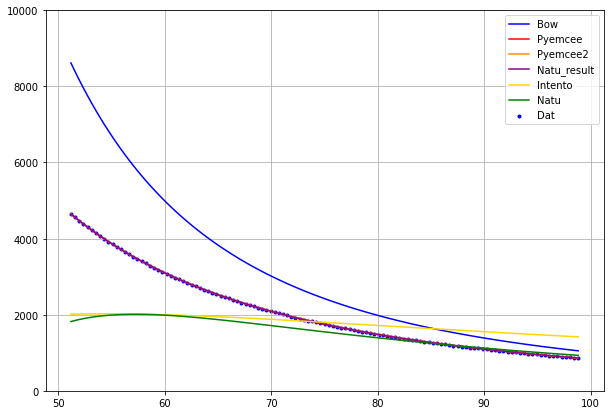

In [15]:
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables
yerr=0.005
plt.figure(figsize=(10,7))
for i in range(len(Cons)):
  Const=Cons[i]
  plt.plot(x,T_sky(x,*Const[0:9]), color=Col[i] ,label=Cons_names[i])
#  plt.plot(x,T_sky(x,*Sol), color='darkred' )
plt.scatter(x,y,marker='.',color='blue',label='Dat')
plt.ylim(0,10000)
plt.legend()
plt.grid()

#(Observación) Aunque los valores estan todos en kelvin , algunas graficas no concuerdan con la optenida por EDGES de la señal de T_Sky

#Funciones de Maxima probalilidad


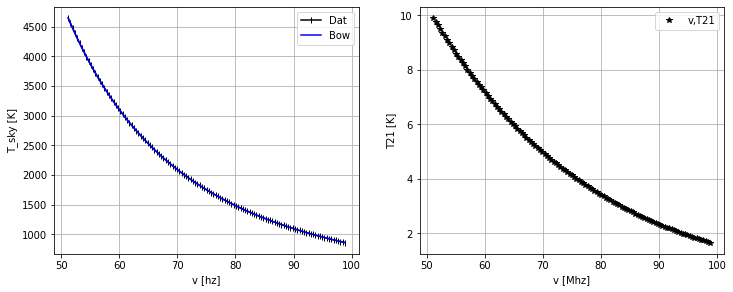

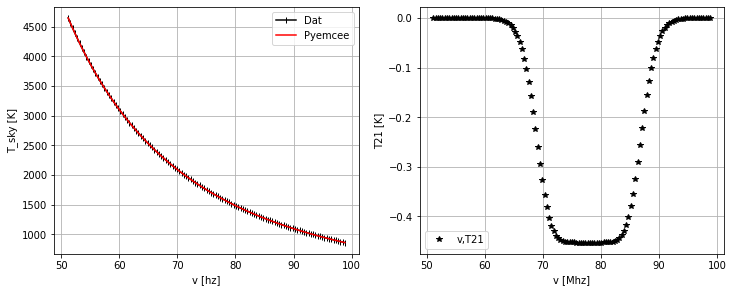

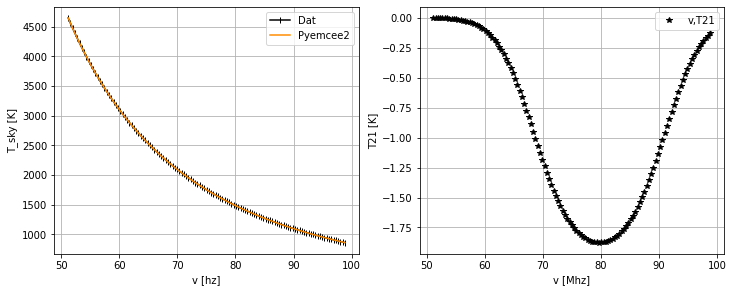

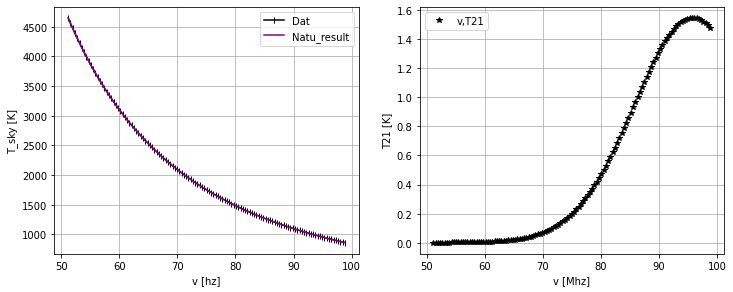

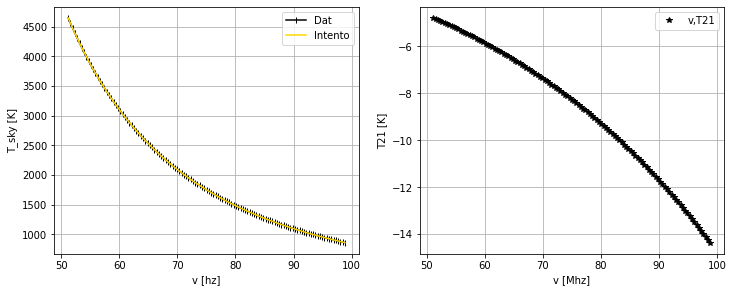

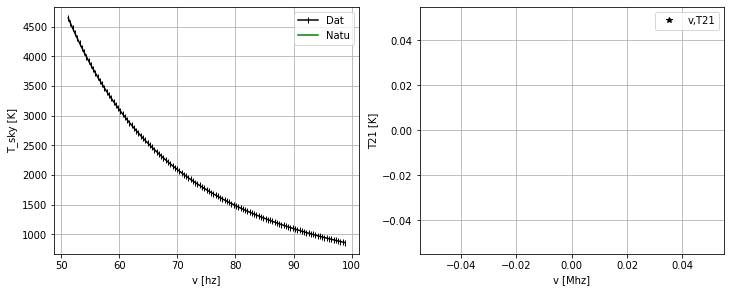

In [16]:
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables

for i in range(len(Cons)):
  sigma=0.005
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=T_modelo(x,y,yerr,Cons[i])
  plt.figure(figsize=(12,10))
  plt.subplot(2,2,1)
  plt.plot(x,y,marker='|',label='Dat',color='k')
  plt.plot(x,T_sky(x,a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1),color=Col[i],label=Cons_names[i])
  plt.xlabel('v [hz]')
  plt.ylabel('T_sky [K]')
  plt.legend()
  plt.grid()
  plt.legend()
  plt.subplot(2,2,2)
  plt.plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21')
  plt.xlabel('v [Mhz]')
  plt.ylabel('T21 [K]')
  plt.legend()
  plt.grid()
  plt.legend()


###(Obs) algunos valores de los parametros ajustan pero no reproducen señal de 21cm

#Cortando los arreglos

En vista que en articulo original de Bowman, solo usan el rango de frecuencias entre $60$ mhz y $94$ mhz, decidimos trabajar el modelo en ese rango para ver si los datos obtenidos se asemejaban mejor a los obtenidos en el texto

In [17]:
x_C,y_C=Dat[:,0][Dat[:,0]>60.0] ,Dat[:,2][Dat[:,0]>60.0] # Variables
x_C,y_C=x_C[x_C<94.0],y_C[x_C<94.0]


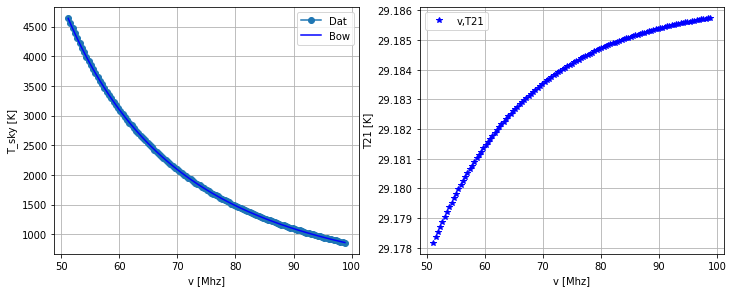

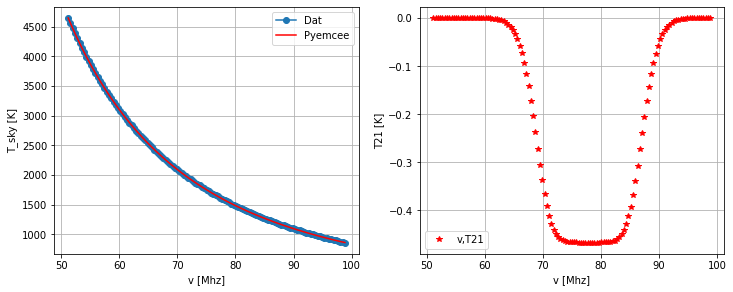

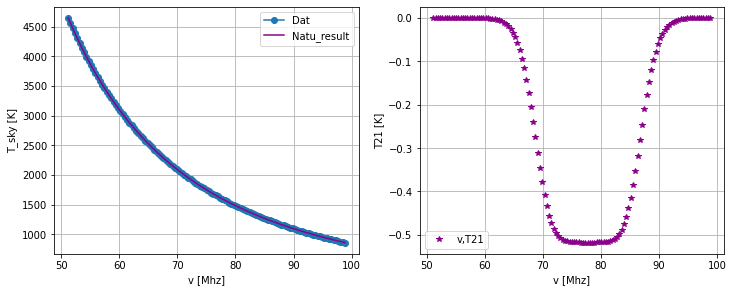

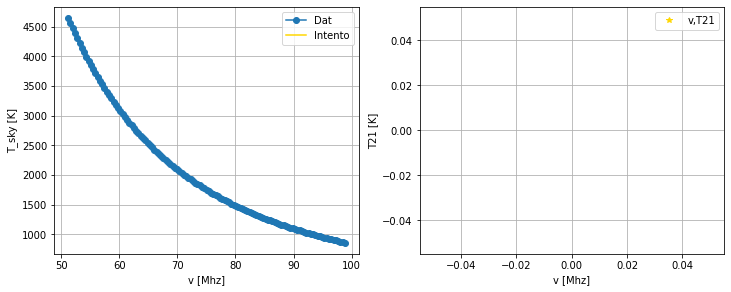

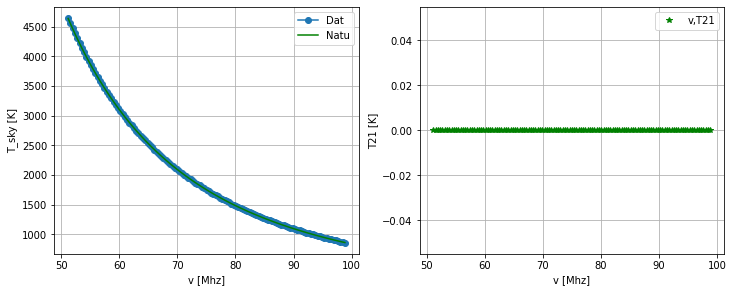

In [18]:
Constantes=np.zeros((6,9))

for i in range(len(Cons)):
  Constantes[i]=T_modelo(x_C,y_C,yerr,Cons[i])
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=Constantes[i]
  plt.figure(figsize=(12,10))
  plt.subplot(2,2,1)
  plt.plot(x,y,marker='o',label='Dat')
  plt.plot(x,T_sky(x,a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1),color=Col[i],label=Cons_names[i])
  plt.xlabel('v [Mhz]')
  plt.ylabel('T_sky [K]')
  plt.legend()
  plt.grid()
  plt.legend()
  plt.subplot(2,2,2)
  plt.plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  plt.xlabel('v [Mhz]')
  plt.ylabel('T21 [K]')
  plt.legend()
  plt.grid()
  plt.legend()

## tabla con los parametros de maxima verosimilitud

In [19]:

Tabla = """\
+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
{}
+-------------------------------------------------------------------------------------------------+\
"""
Tabla = (Tabla.format('\n'.join("| {:<15} {:<15} {:<15} {:<15}{:<15} {:<15}  |".format(*fila)
 for fila in np.round(np.transpose(Constantes),3))))
print (Tabla)

+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
| 959.422         -11225.58       1741.828        -14303.655     9849617.44      290.626          |
| -1178.444       -14175.02       131.67          -17465.644     -4512518.184    -2017.395        |
| -943.845        -10204.678      -661.573        -12696.645     -2955764.154    -560.584         |
| -11.173         144.513         34.948          188.551        -5599828.288    -46.622          |
| 604.88          12663.883       -192.716        15697.972      4198857.413     1338.304         |
| -29.186         0.467           1.712           0.518          4479867.409     238.704          |
| 139.482         77.95           78.572          77.784         23129781.219    -68.177          |


# Nwalkers 
 Hora vamos a observar los resultados de los nwlakers en los diferentes parámetros


La tabla anterior tiene los valores medios de los walker de los diferentes parametros

##Grafico de esquina:

100%|██████████| 10000/10000 [09:30<00:00, 17.54it/s]


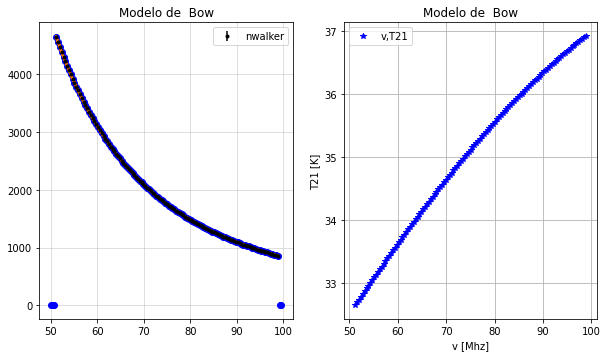

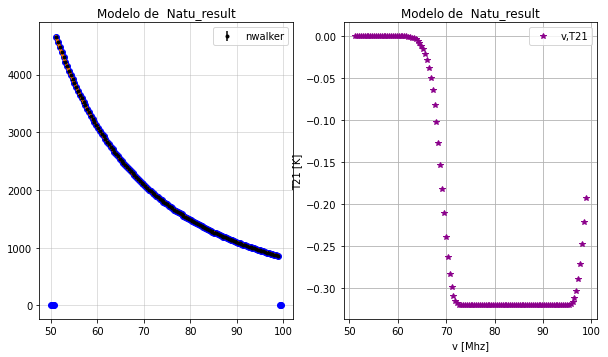

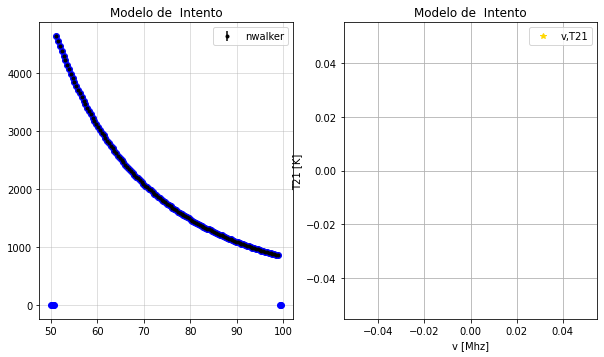

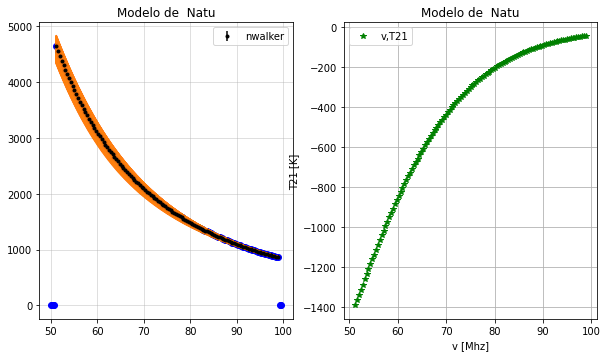

In [21]:
steps=10000 #pasos
Ncons= (len(Cons[0]))-1 # número de constantes (en este caso esta el menos 1 ya que los arreglos tienen el parametro sigma )

cc=np.zeros((len(Cons),len(Cons[0])-1))  # Este arreglo vacio, va a contener los valores principales de los parametros
rr=np.zeros((len(Cons),22500,len(Cons[0])-1)) #Este arreglo vacio va a contener los n walkers  de los parametross
for i in range(len(Cons)):
  Sol=T_modelo(x_C,y_C,yerr,Cons[i])
  params=nwlakers1(x_C,y_C,0.5,Sol[0:9],9,2500,steps,i)
  popt2=np.array(params.mean(axis=0))
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt2
  rr[i]=params
  cc[i]=(popt2 )
  plt.figure(figsize=(10,12))
  plt.subplot(2,2,1)
  plt.plot(Dat[:,0],Dat[:,2],'bo')
  for j in range(len(params)):
    ms=params[j]
    ms=ms[0:9]
    plt.plot(x,T_sky(x,*ms), "C1", alpha=0.1)
  plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0,label='nwalker') #Grafica la muetras con su respectivo error
  #plt.xlim(min(x),max(x))
  plt.title('Modelo de  ' +Cons_names[i])
  #plt.ylim(min(y),max(y))
  plt.legend()
  plt.grid(alpha=0.5)
  plt.subplot(2,2,2)
  plt.plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  plt.title('Modelo de  ' +Cons_names[i])
  plt.xlabel('v [Mhz]')
  plt.ylabel('T21 [K]')
  plt.legend()
  plt.grid()
  plt.legend()

In [ ]:
Tabla = """\
+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
{}
+-------------------------------------------------------------------------------------------------+\
"""
Tabla = (Tabla.format('\n'.join("| {:<15} {:<15} {:<15} {:<15}{:<15} {:<15}  |".format(*fila)
 for fila in np.round(np.transpose(cc),3))))
print (Tabla)

+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
| 2590.769        -5528.899       1757.478        -14287.174     84689.544       -1057.039        |
| 2681.293        -8097.699       155.754         -17456.957     73900.389       -3465.432        |
| -9022.369       -5575.092       -664.899        -12663.988     95034.407       -1634.846        |
| 524.415         60.744          35.988          186.799        -3802.659       -28.645          |
| -1801.683       7051.027        -209.377        15683.238      -79193.284      2667.954         |
| -268.87         0.464           1.738           0.488          111.729         262.825          |
| 208.488         78.049          78.548          77.773         87.463          -37.958          |


Bow


<Figure size 432x288 with 0 Axes>

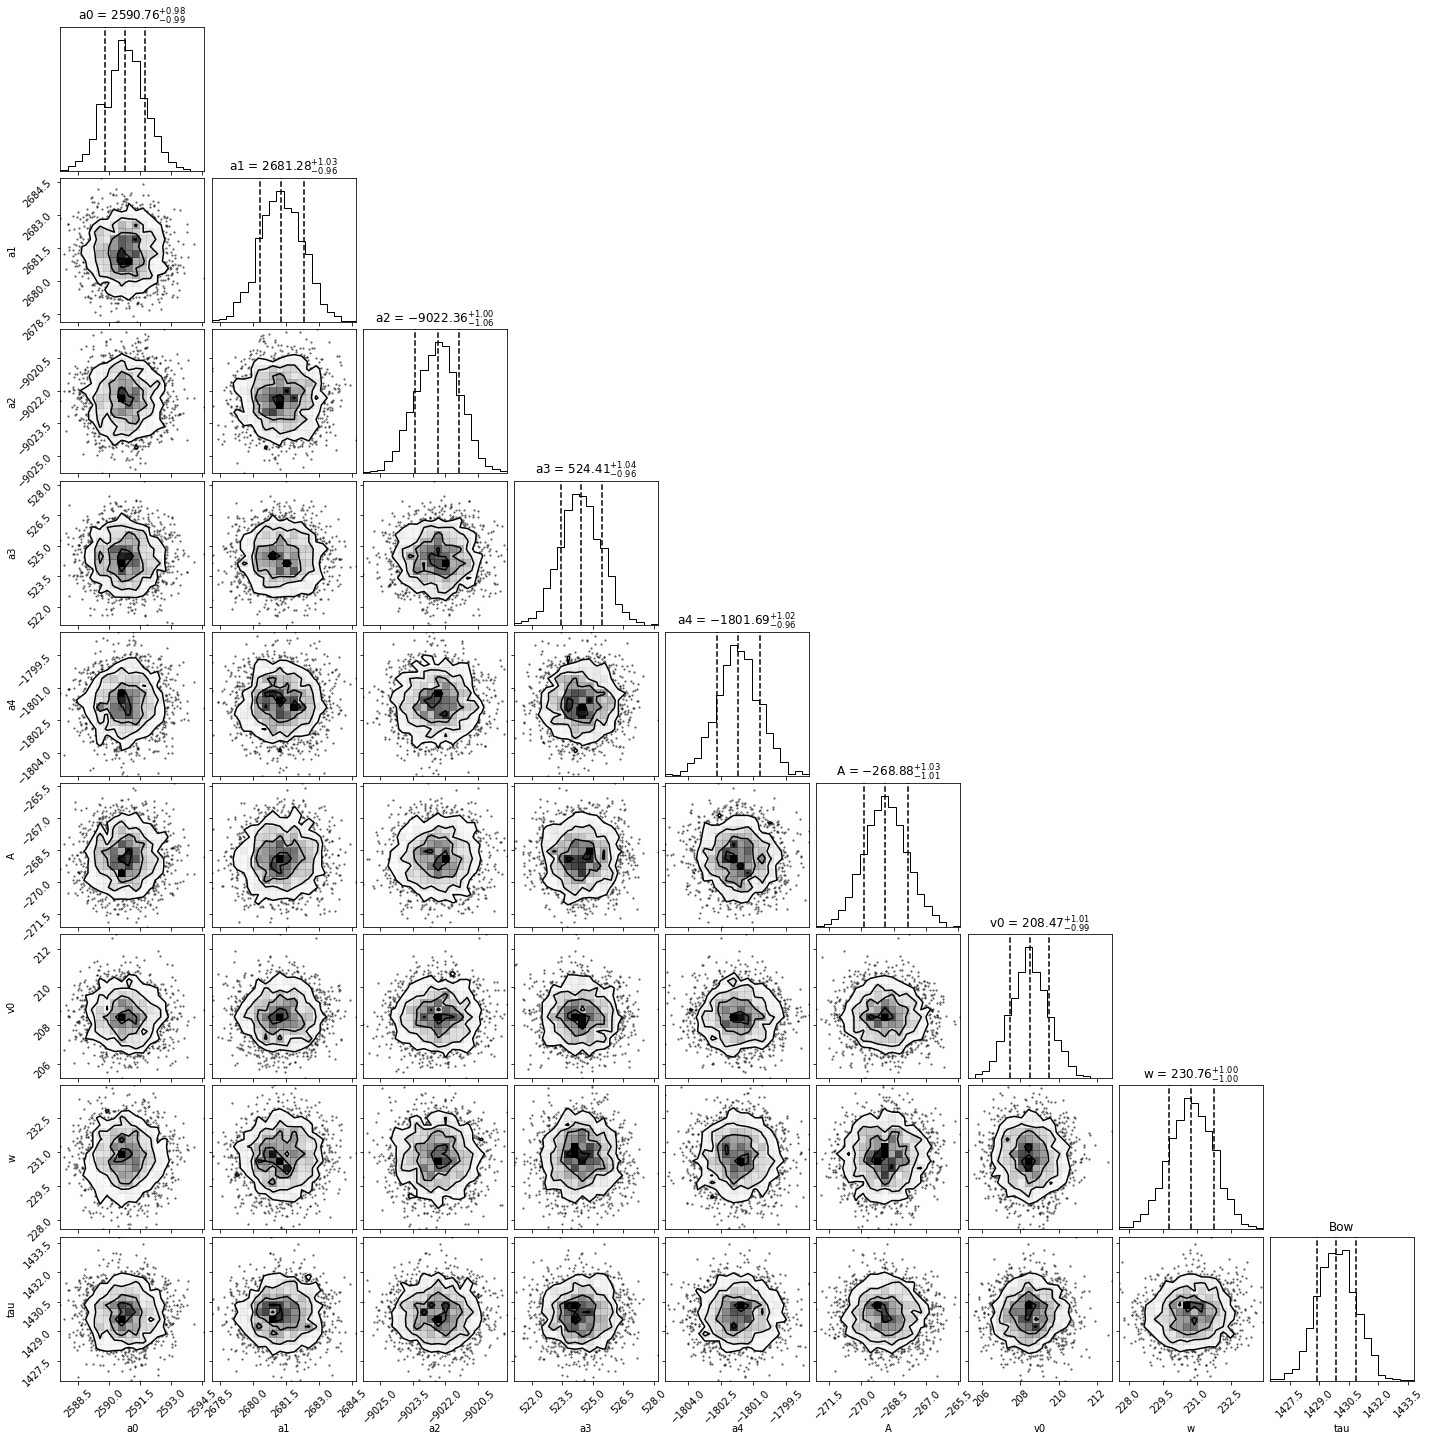

Pyemcee


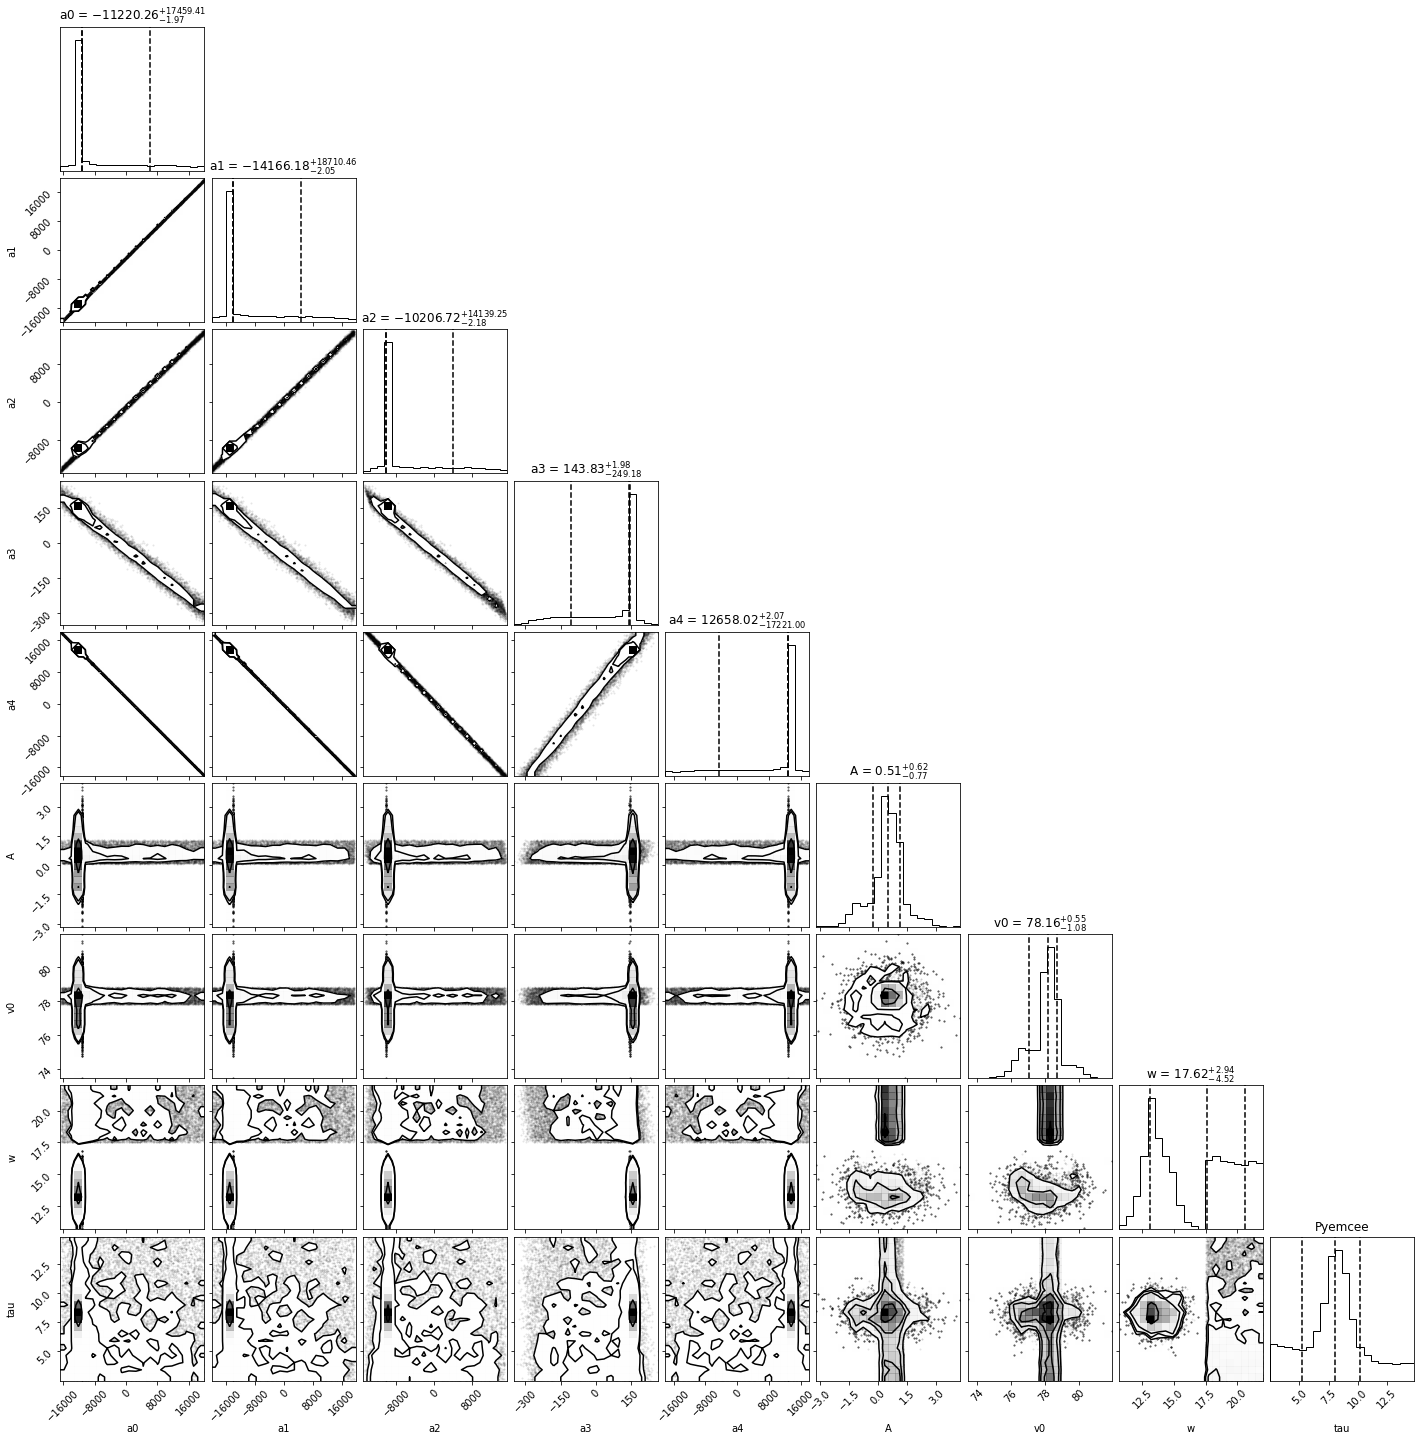

Pyemcee2


Natu_result


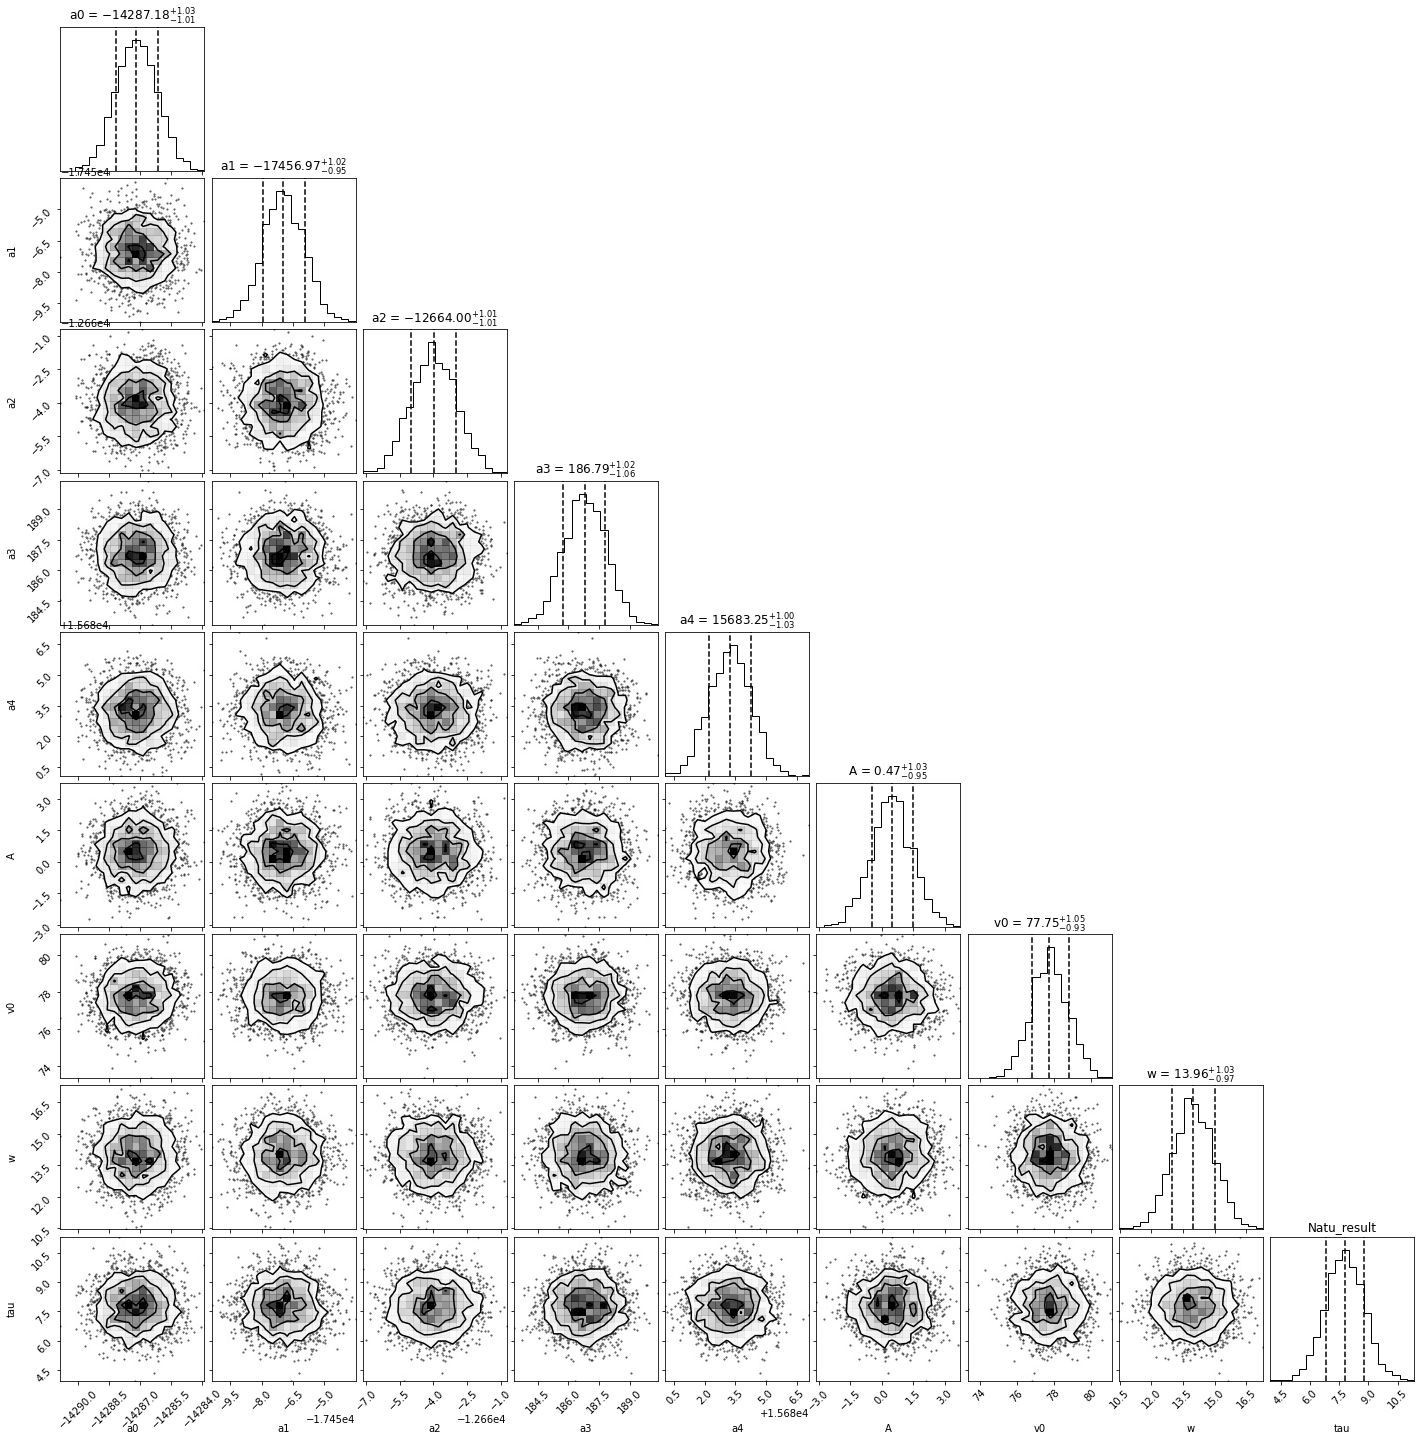

Intento


Natu


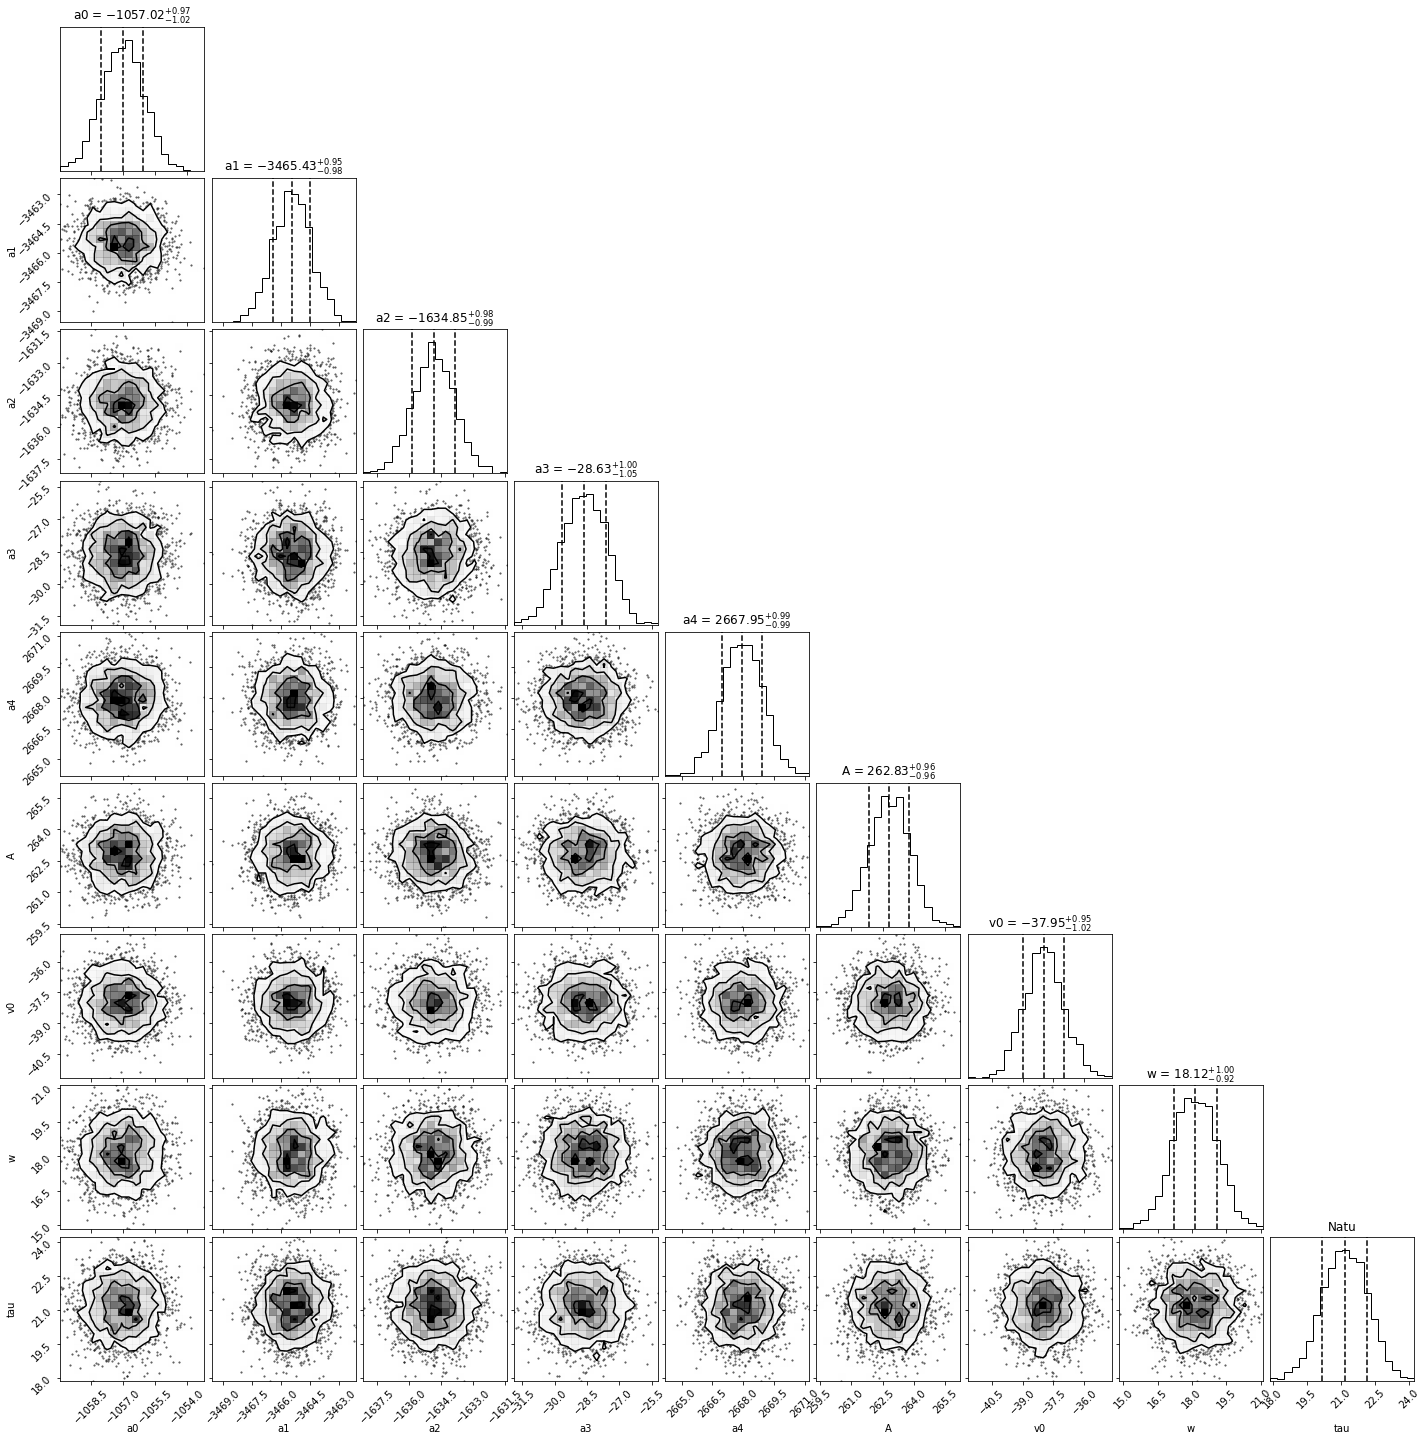

In [ ]:
names=np.array(['a0','a1','a2','a3','a4','A','v0','w','tau'])
plt.figure()
for i in range(len(Cons)):
  
  print(Cons_names[i])
  corner.corner(rr[i],labels=names,quantiles=[0.16, 0.5, 0.84],show_titles=True)
  plt.title(Cons_names[i]) 
  plt.show()

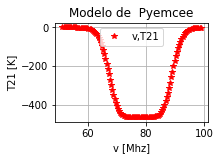

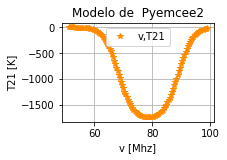

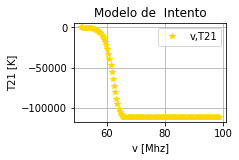

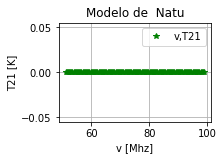

In [ ]:
for i in range(len(Cons)):
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=cc[i]
  plt.figure()
  plt.title('Modelo de  ' +Cons_names[i])
  #plt.ylim(min(y),max(y))
  plt.legend()
  plt.grid(alpha=0.5)
  plt.subplot(2,2,2)
  plt.plot(x,T_21(x,A1*1000,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  plt.title('Modelo de  ' +Cons_names[i])
  plt.xlabel('v [Mhz]')
  plt.ylabel('T21 [K]')
  plt.legend()
  plt.grid()
  plt.legend()
    #ms=rr[j]
    #ms=ms[0:9]
    #plt.plot(x,T_sky(x,*ms), "C1", alpha=0.1)
  #plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0,label='nwalker') #Grafica la muetras con su respectivo error
  #plt.xlim(min(x),max(x))


In [ ]:
np.shape(cc[i])

(9,)

#Tiempo de Autocorrelación


In [ ]:
names=np.array(['a0','a1','a2','a3','a4','A','v0','w','tau'])
for j in range(9): # Range NConstans
    autocorr=[]
    for i in range(2500): # Range NWalker 
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           names,
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

"""     
    autocorr=np.asarray(autocorr)
print("Autocorrelation time for "+str(names))
autocorr_=autocorr
plt.figure()
plt.hist(autocorr_,alpha=0.5)
print("Mean: ",autocorr_.mean(),"Stdev: ",autocorr_.std())
plt.title(names[j])
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
          names,
          scatterpoints=1,
          loc='upper right',
          ncol=10,
          fontsize=11)
"""

NameError: ignored

#Residuales

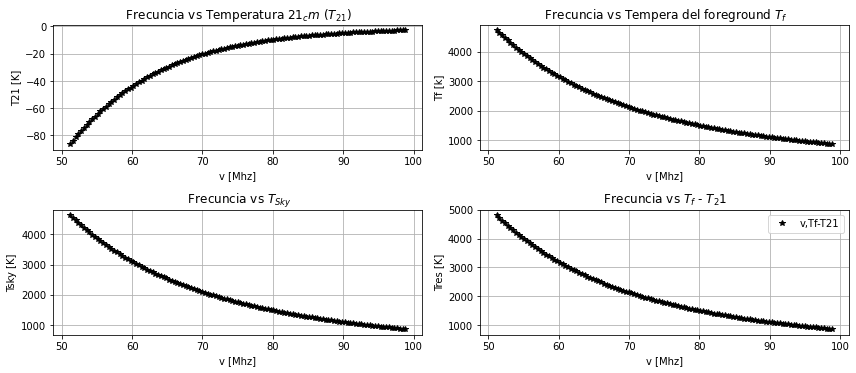

In [ ]:
a0,a1,a2,a3,a4,A,v0,w,tau=popt2
v=x
plt.figure(figsize=(12,10))
plt.subplot(4,2,1)
plt.plot(v, T_21(v,A,v0,w,tau),'k*')
plt.title(' Frecuncia vs Temperatura $21_cm$ ($T_{21}$) ')
plt.xlabel('v [Mhz]')
plt.ylabel('T21 [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,2)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4),'k*')
plt.title(' Frecuncia vs Tempera del foreground $T_f$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tf [k]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,3)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4)+ T_21(v,A,v0,w,tau),'k*')
plt.title(r' Frecuncia vs $T_{Sky}$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tsky [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,4)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4)- T_21(v,A,v0,w,tau),'k*',label='v,Tf-T21')
plt.title(' Frecuncia vs $T_f$ - $T_21$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tres [K]')
plt.legend()
plt.tight_layout()
plt.grid()

In [ ]:
steps=100 #pasos
Ncons= (len(Cons[0]))-1 # número de constantes (en este caso esta el menos 1 ya que los arreglos tienen el parametro sigma )

cc=np.zeros((len(Cons),len(Cons[0])-1))  # Este arreglo vacio, va a contener los valores principales de los parametros
rr=np.zeros((len(Cons),steps,len(Cons[0])-1)) #Este arreglo vacio va a contener los n walkers  de los parametross
autocorr_time=np.zeros((Ncons,1000))
for i in range(len(Cons)):
  Sol=T_modelo(x_C,y_C,yerr,Cons[i])
  sampler=nwlakers(x_C,y_C,0.5,Sol[0:9],Ncons,2500,steps)
  autocorr=Time_autocorr(sampler,i,Ncons,2500)
  popt2=np.array(params.mean(axis=0))
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt2
 # rr[i]=params
 # cc[i]=(popt2 )


In [ ]:
r=np.zeros(np.shape(params))
rr=np.zeros((6,10000,9))
np.shape(rr[2])
len(rr[0])
rr[0]=params
len(Cons[0])
cc[0 ]

In [ ]:


#longitud del arreglo

from ipywidgets import *

def T_modelo(x,y,yerr,const):
  a0,a1,a2,a3,a4,A,v0,w,tau,sigma= const             # intersección con el eje y
  nll=lambda *args: -log_likelihood(*args) # Construccion de la funcion lamda 
  v=x
  N=len(x) 
  vc=78.0
  #Condiciones iniciales

  In=np.array([a0,a1,a2,a3,a4,A,v0,w,tau]) + 0.1 * np.random.randn(9)
  #Solución
  Sol=minimize(nll,In,args=(x, y, yerr))
  # Extrayendo los valores de los parametros arojados por MlE
  popt = Sol.x
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt

  return popt

In [ ]:
def nwlakers(x,y,yerr,Sol,N,walkers,steps):
  pos = Sol+ 10e-1 * np.random.randn(walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params
  """
  plt.figure(figsize=(8,5))
  plt.plot(Dat[:,0],Dat[:,2],'bo')
  for j in range(len(params)):
    ms=params[j]
    ms=ms[0:9]
    plt.plot( ,T_sky(x,*ms), "C1", alpha=0.1)
  plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0,label='nwalker') #Grafica la muetras con su respectivo error
  #plt.xlim(min(x),max(x))
  plt.title('Modelo')
  #plt.ylim(min(y),max(y))
  plt.legend()
  plt.grid(alpha=0.5)
  """